## Assignment 8: Tree-based techniques

#### Introduction

**Goal:** 
* In this lab we will be predicting the glass formability in the Co-Ti-Cr-Zr system, using Decision Tree Classifier and Random Forest Classifier trained on a variety of alloy systems. 

**Approach:** 

* The best hyperparameters for the models are identified via Grid Search CV, for which AUC score is used as the metric. 
    * Leave-one-group-out was used for the grid search, since we are predicting a different alloy system and will need to test the model's anility to generalize & extrapolate.

Q to ask:

* if I put standardization and LassoCV together in a pipeline, wouldn't that standardize the entire X before it is feed into cross-validation?

* When performing LOCO-CV, is it true that we are deliberately violating IID? 
    * if not: There is a possibility that when performing clustering, we are unwittingly clustering apart MGs from non-MGs - if so, doesn't a clustering on that violate IID?

* LDA was likened to PCA for their similarity in separating clusters, but LDA can also act as a classifier by .fit and .predict. How does that work? Can I do clustering by LDA's algorithm? (probably not as LDA is supervised)

    * LDA have methods including .fit(X, y) and .fit_transform(X) where y is default _None_. On sklearn website it says it's an unsupervised transformation when y=None. Does that mean it is doing a job similar to PCA?

In [1]:
import numpy as np
import numpy.matlib as nm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('glass.data', sep = ' ')
df.head(10)

,comp,"gfa{AM,AC,CR}"
0,Ag20Al25La55,AM
1,Ag15Al10Mg75,AM
2,Ag25Al10Mg65,AM
3,Ag25Al20Mg55,AM
4,Ag35Al10Mg55,AM
5,Ag35Al20Mg45,AM
6,Ag45Al20Mg35,AM
7,Ag10Ce6Cu84,AM
8,Ag10Ce10Cu80,AM
9,Ag15Ce6Cu79,AM


### 0. Perform data cleaning

* drop nan

* substitute AC labels as CR

* subs CR as 0, AM as 1 (for glass formability)

* DELIVER: a simple, cleaned, usable dataframe

In [3]:
df = df.dropna()

# change the name of the last column to 'isAmor'
df = df.rename(columns={'gfa{AM,AC,CR}': 'isAmor'})

# for the values in isAmor, change the values to 1 if it is AM, 0 if anything else
df['isAmor'] = df['isAmor'].apply(lambda x: 1 if x == 'AM' else 0)

In [4]:
df.head(10)

,comp,isAmor
0,Ag20Al25La55,1
1,Ag15Al10Mg75,1
2,Ag25Al10Mg65,1
3,Ag25Al20Mg55,1
4,Ag35Al10Mg55,1
5,Ag35Al20Mg45,1
6,Ag45Al20Mg35,1
7,Ag10Ce6Cu84,1
8,Ag10Ce10Cu80,1
9,Ag15Ce6Cu79,1


### 1. Generate and Select Features

* generate features, save dataframe to file

* drop non-numerical features and zeros features, save as new dataframe

* drop correlated features using custom functions

* DELIVER: X, y

In [5]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema, Meredig, WenAlloys, AtomicPackingEfficiency

# dff = df.copy()
# dff = StrToComposition().featurize_dataframe(dff, 'comp')
# dff = AtomicPackingEfficiency().featurize_dataframe(dff, col_id='composition')
# dff = Miedema().featurize_dataframe(dff, col_id='composition')
# dff = Meredig().featurize_dataframe(dff, col_id='composition')
# dff = WenAlloys().featurize_dataframe(dff, col_id='composition')

# dff.to_excel('dff.xlsx', index = False)

In [6]:
dff = pd.read_excel('dff.xlsx')
dff = dff.dropna()

print('before dropping there are ', len(dff.columns)-2, 'features')

# drop the column if the entire column is 0
dff = dff.loc[:, (dff != 0).any(axis=0)]
# drop the column 'Weight Fraction' and 'Atomic Fraction'
dff = dff.drop(['Weight Fraction', 'Atomic Fraction'], axis=1)

'''From dff we create a few new variables: 
- features_all, a df used only for correlation analysis
    - yang_df, which has the yang features
After dropping correlated ones:
    - X, spun off from features
    - y, the target value'''

# make a new df with only the numerical features
features_all = dff.iloc[:, 3:]
print('after dropping there are ', len(features_all.columns), 'features')

before dropping there are  154 features
after dropping there are  99 features


In [7]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

X = features_all.values
y = dff['isAmor'].values

# define yang_df as the df with the column 'Yang delta' and 'Yang omega
yang_df = features_all[['Yang delta', 'Yang omega']]

from CustomFunctions import lasso_squash
indx = lasso_squash(X, y, alpha = 0.01) # this alpha value is chosen by trial and error.the optimal alpha leaves to too many features

# drop the columns corresponding to the indexes in indx
features = features_all.drop(features_all.columns[indx], axis=1)

# re-assign X to be the features after the squash
X = features.values

input α is used
before lasso there are  99 features
after lasso there are  37 features



#### _Preparing for next steps: Clustering with PCA/LDA & Add labels for LOCO-CV_

* use PCA + Spectral Clustering to separate clusters

* DELIVER: the cluster label

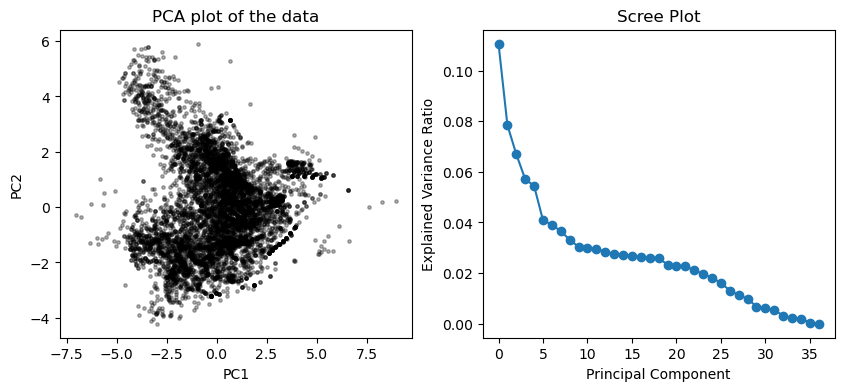

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

from CustomFunctions import pca_plot

X_pca = pca_plot(X, n_comp = 6, title = 'PCA plot of the data', return_scree=True)

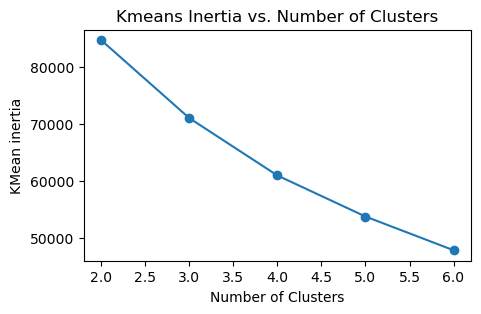

In [9]:
# Next, we want the labels, so need to DETERMINE THE NUMBER OF CLUSTERS (labels) to put data into
from sklearn.cluster import KMeans
ks = [2, 3, 4, 5, 6]
# Loop through different values of k
inertia = []
for k in ks:
    # Perform clustering with KMeans
    KM = KMeans(n_clusters=k, random_state=0).fit(X_pca)
    # calculate the inertia
    inertia.append(KM.inertia_)

# define figure size
plt.figure(figsize=(5, 3))
# Plot the inertia for each value of k, use round dot markers
plt.plot(ks, inertia, marker='o')
plt.title('Kmeans Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('KMean inertia')
plt.show()

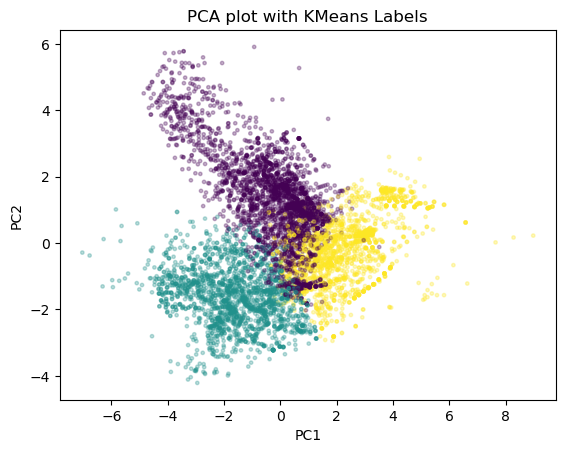

In [10]:
# from the graph above, 3 clusters seems fine. Generate labels:
KM = KMeans(n_clusters=3).fit(X_pca)
labels = KM.labels_
# plot the clusters
pca_plot(X_pca, n_comp = 6, standardize = False, title = 'PCA plot with KMeans Labels', color_label = labels);

### 2. Test DTC's performance of classifying **"isAmor"**

* Using DTC, perform loco CV on DTC, use cluster label from before. Code modified from custom function. 
    * DELIVER: ConfMatrix, ROC curve (k ROC curves in one plot)


* Perform random CV on grid of hyper-para (not very helpful to do 5-fold RandomCV with same hyper-para), and contour-plot the validation error in grid of hyper-para. 

    * DELIVER: ConfMatrix, ROC curve (k-curve in one plot)
    * Parameter Grid contour plot, Optimal hyper parameters



Val. AUC at split 1 0.5624005293899818
Val. AUC at split 2 0.5434774598361864
Val. AUC at split 3 0.6440927218344965


/Users/baishipu/Desktop/403 Python/MSE403 Baishi Pu 1004916184/Assi 8/CustomFunctions.py:626: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


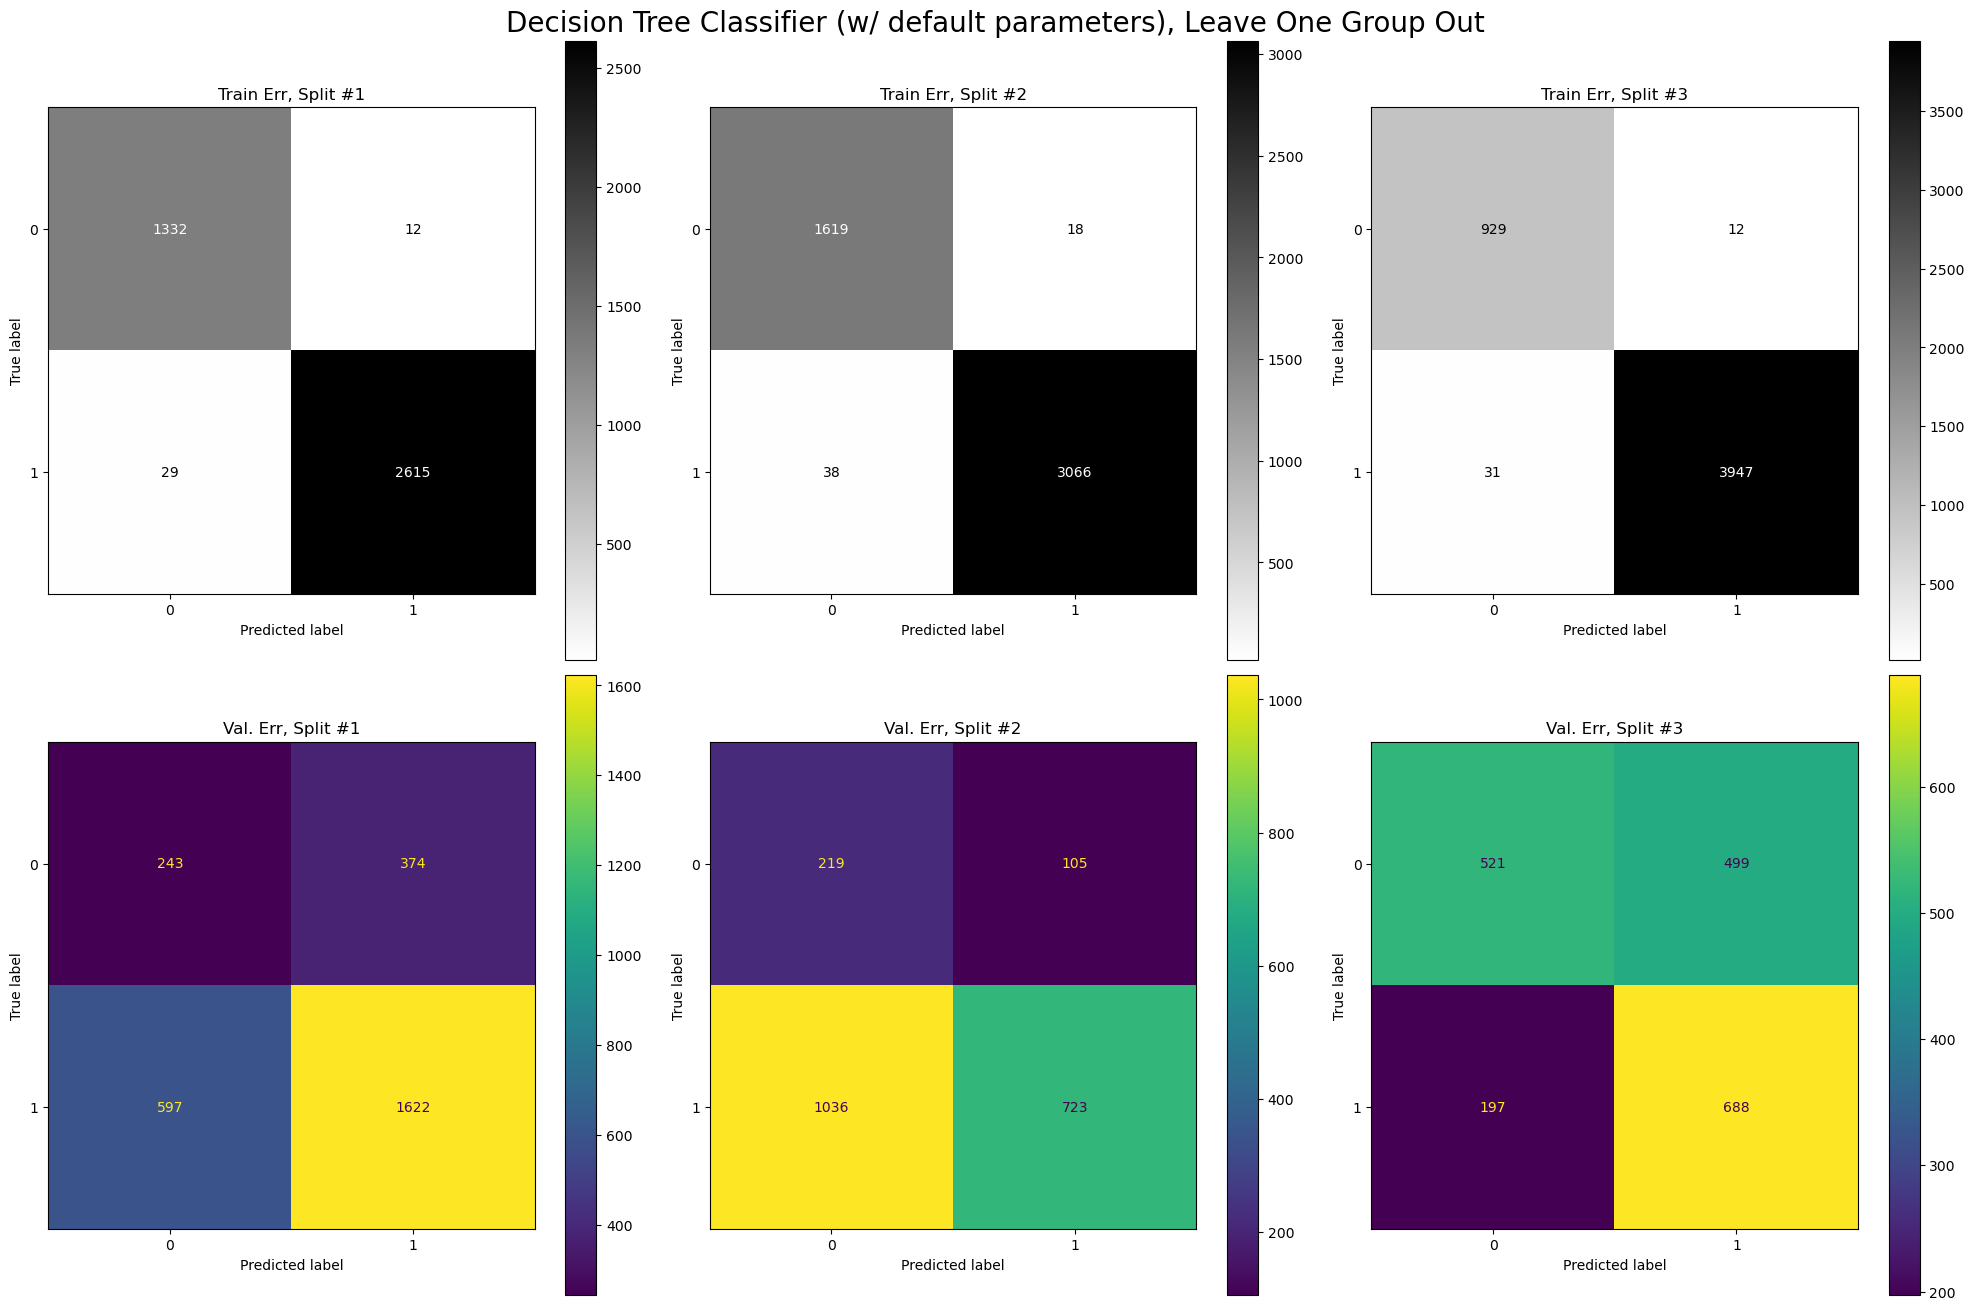

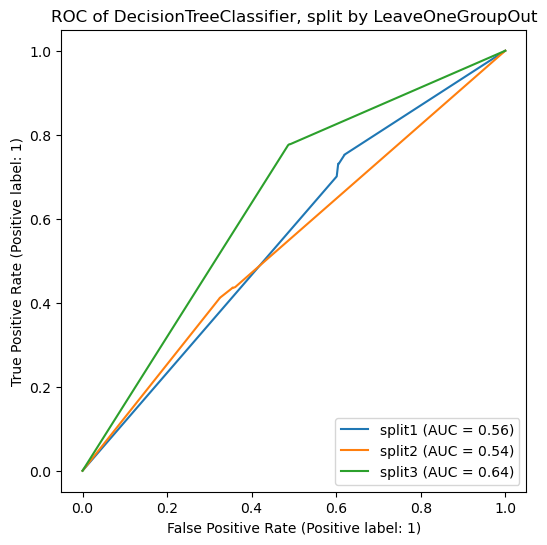

In [11]:
from sklearn.model_selection import LeaveOneGroupOut
from CustomFunctions import CrossValidate
# from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay

from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
LOGO = LeaveOneGroupOut()
CrossValidate(DTC, X, y, task_type = 'classification', splitter = LOGO, cv_label=labels, 
              title = 'Decision Tree Classifier (w/ default parameters), Leave One Group Out')

_THOUGHTS: training error is low, AUC curve not shown here but can be above 0.95; meanwhile very unideal performance during validation with LOCOcv_

Optimal Parameteres:  {'max_depth': 9, 'min_samples_split': 11}


Text(50.722222222222214, 0.5, 'max_depth')

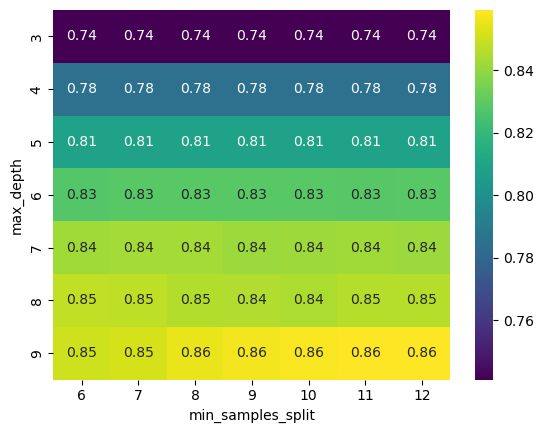

In [12]:
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sb

params = {'min_samples_split': [6, 7, 8, 9, 10, 11, 12],
          'max_depth': [3, 4, 5, 6, 7, 8, 9]}
X_std = StandardScaler().fit_transform(X)

KF = KFold(n_splits=5, shuffle=True, random_state=0)

DTC = DecisionTreeClassifier(random_state=6)

GSCV = GridSearchCV(DTC, param_grid=params, scoring='roc_auc', cv=KF, n_jobs=-1).fit(X_std, y)
print('Optimal Parameteres: ', GSCV.best_params_)

Z = GSCV.cv_results_['mean_test_score'].reshape(
    len(params['max_depth']), len(params['min_samples_split']))

'''INSTEAD OF CONTOUR PLOT, we plot he heatmap as it allows better visualization of 
the numeric score of each combination'''
sb.heatmap(Z, cmap='viridis', annot=True, xticklabels=params['min_samples_split'], 
           yticklabels=params['max_depth'])
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')

_THOUGHTS: from the graph above, max depth of 4 is good enough, and minimum sample per split does not affect the score too much_

In [13]:
# based on the above heatmape, we select max_depth = 4 and min_samples_split = 12
# here X is not standardized - the tree was the same with or without standardization
DTC = DecisionTreeClassifier(min_samples_split=12, max_depth=4).fit(X_std, y)

feature_names = list(features.columns)
class_names = ['amorphous', 'crystalline']
# # print the decision tree
# from sklearn.tree import export_graphviz
# # !pip install graphviz
# import graphviz


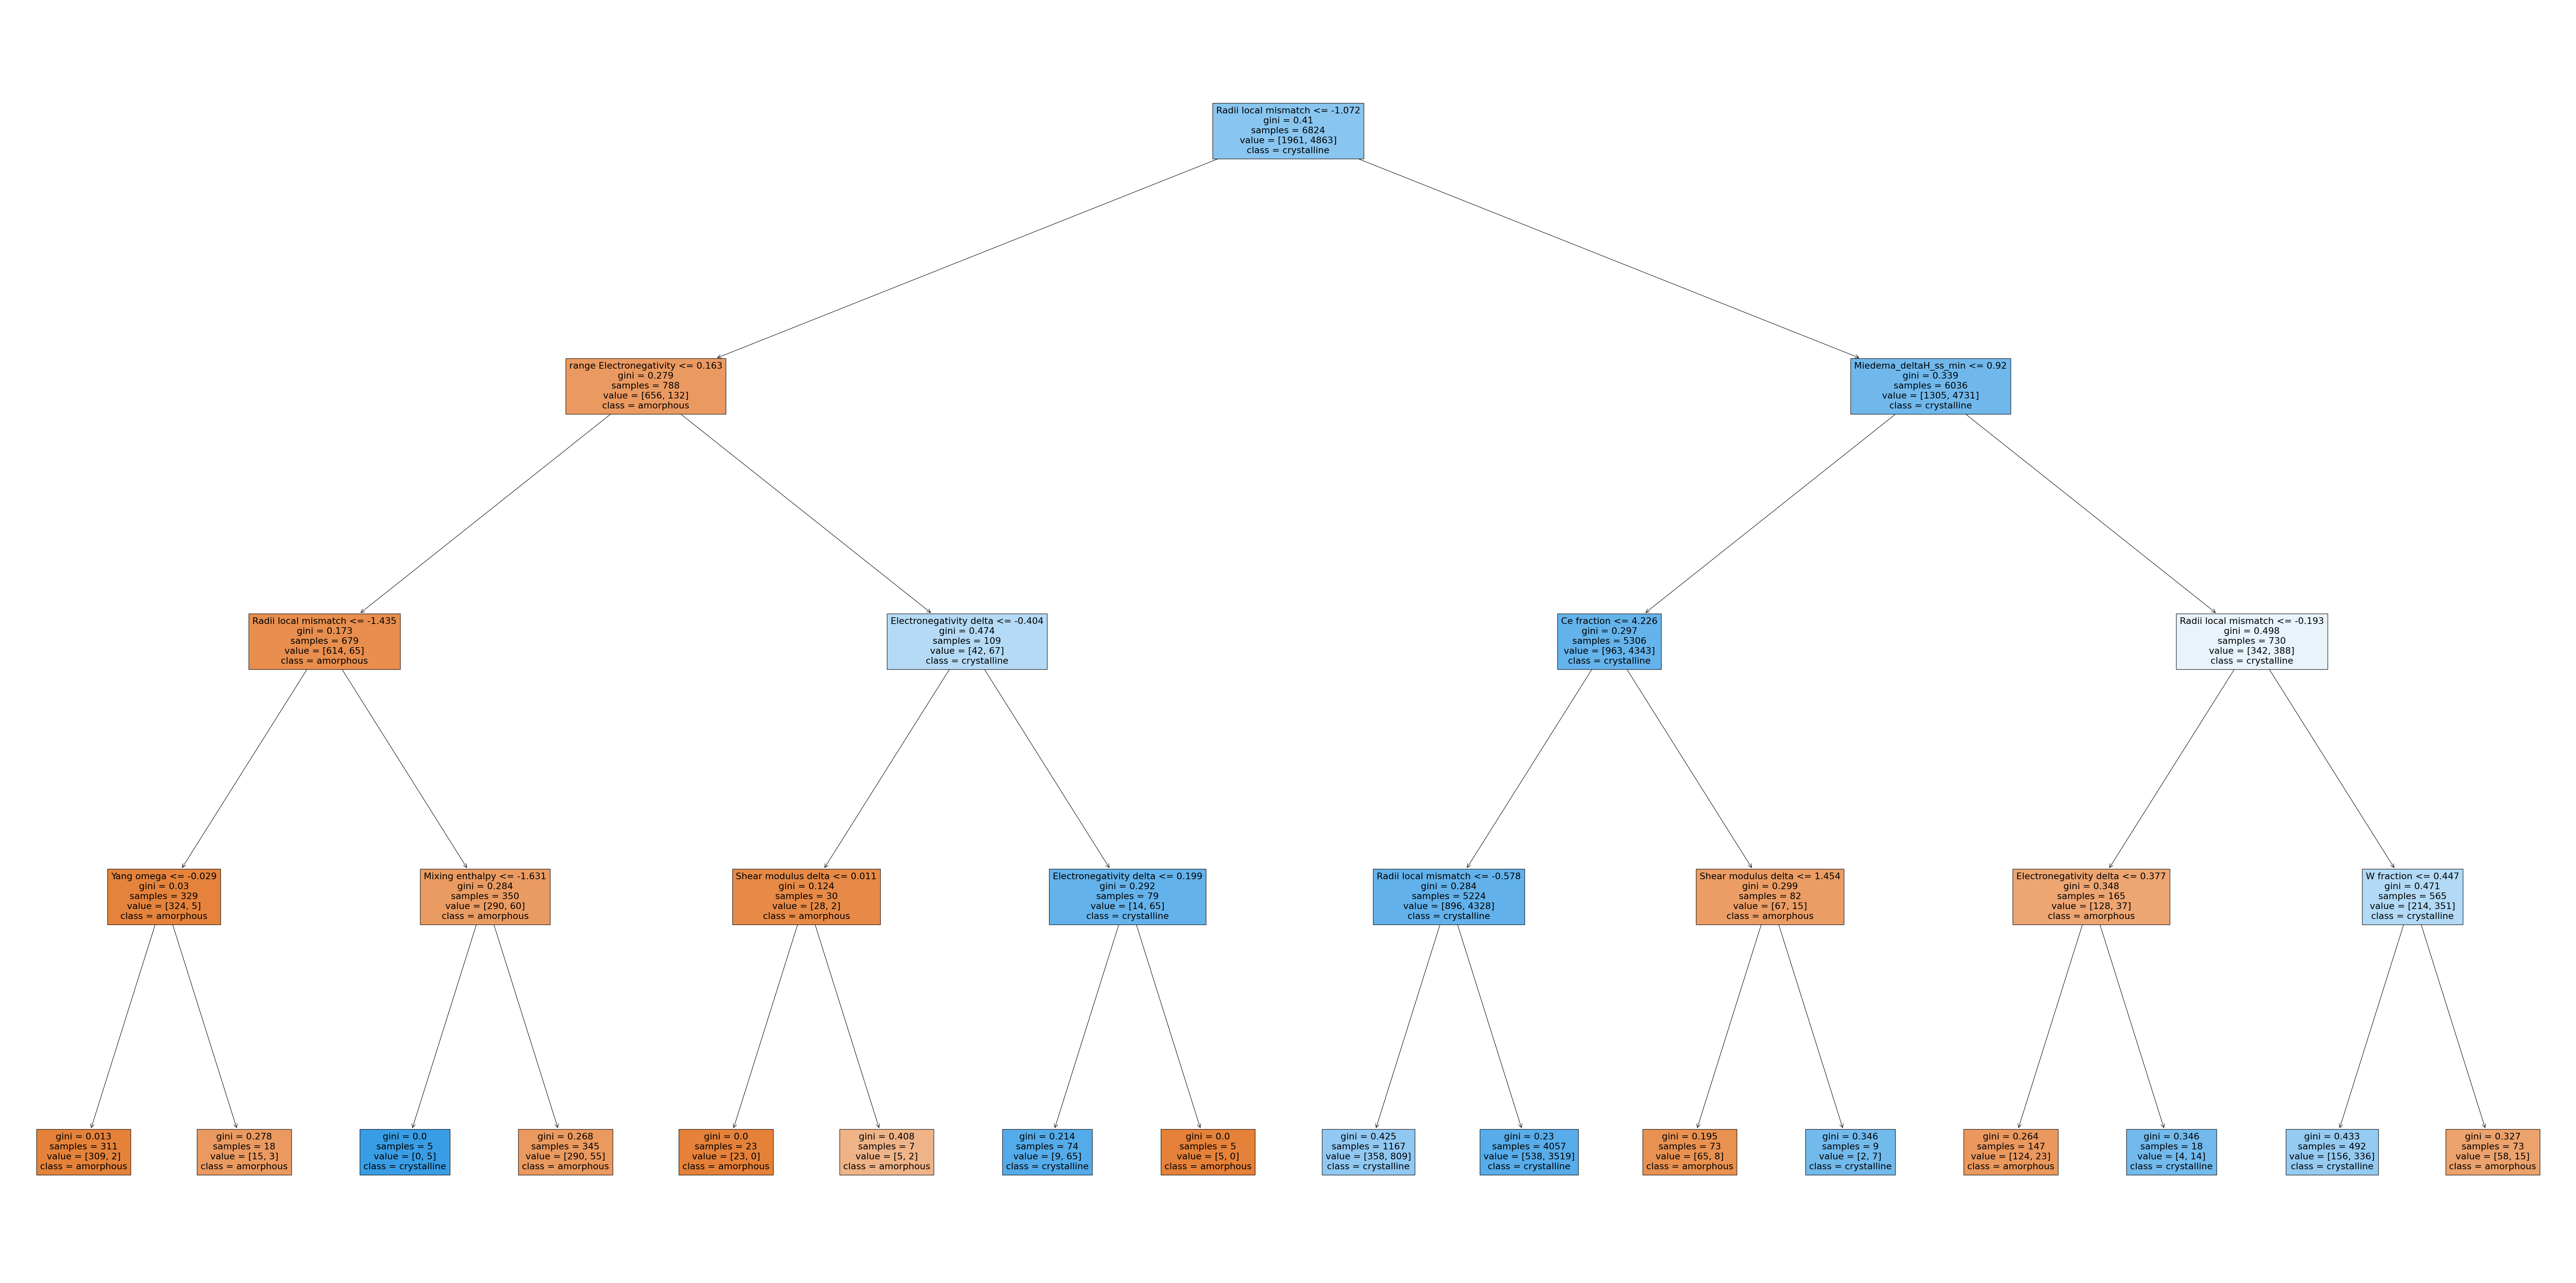

In [14]:
from sklearn.tree import plot_tree
# make plot size bigger
plt.figure(figsize=(100, 50))
plot_tree(DTC ,feature_names=feature_names,  class_names=class_names,filled=True);

Text(0, 0.5, 'Features Ranked by Importance')

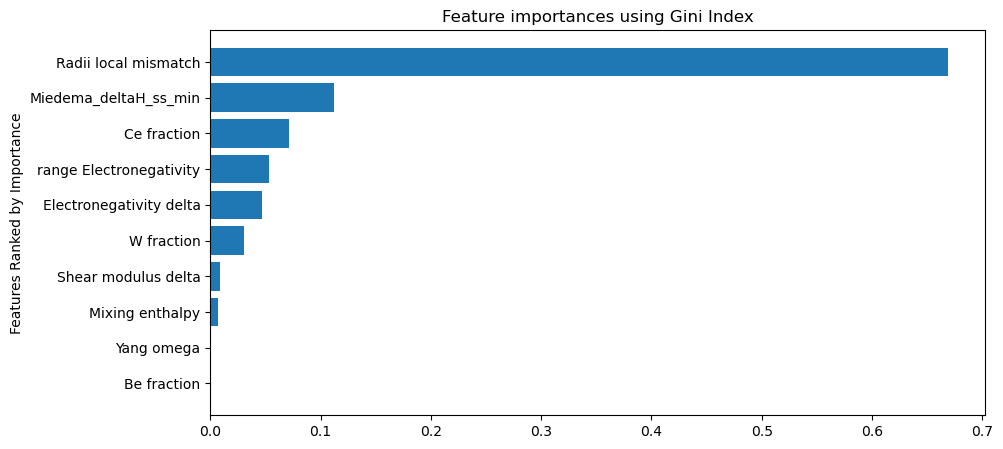

In [15]:
# below codes modified from PRA 9
importance = DTC.feature_importances_ #using Gini importance implemented by Sklearn (Mean decrease in impurity)

# plot feature importance
sort = importance.argsort()[-10:]
plt.figure(figsize=(10, 5))
plt.barh(features.columns[sort], importance[sort])
plt.title("Feature importances using Gini Index")
plt.ylabel("Features Ranked by Importance")

_THOUGHTS: based on the printed decision tree, Radii Local Mismatch is the top node, followed by Range of electronegativity and Miedma delta SS min at depth = 1._

_The feature importance graph shoes likewise. Other than the Ce fraction (which could have negative effect for model performance), this is somewhat consistent with our previous results_

### 3. Train a Random Forest Classifier

* Using RFC, perform loco CV on RFC, use cluster label from before. Code modified from custom function. 
    * DELIVER: ConfMatrix, ROC curve (k ROC curves in one plot)

* Perform random CV on grid of hyper-para (not very helpful to do 5-fold RandomCV with same hyper-para), and contour-plot the validation error in grid of hyper-para. 

    * DELIVER: ConfMatrix, ROC curve (k-curve in one plot)
    * Parameter Grid contour plot, Optimal hyper parameters

Val. AUC at split 1 0.5858136924147794
Val. AUC at split 2 0.6229865453856359
Val. AUC at split 3 0.536731472249917


/Users/baishipu/Desktop/403 Python/MSE403 Baishi Pu 1004916184/Assi 8/CustomFunctions.py:626: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


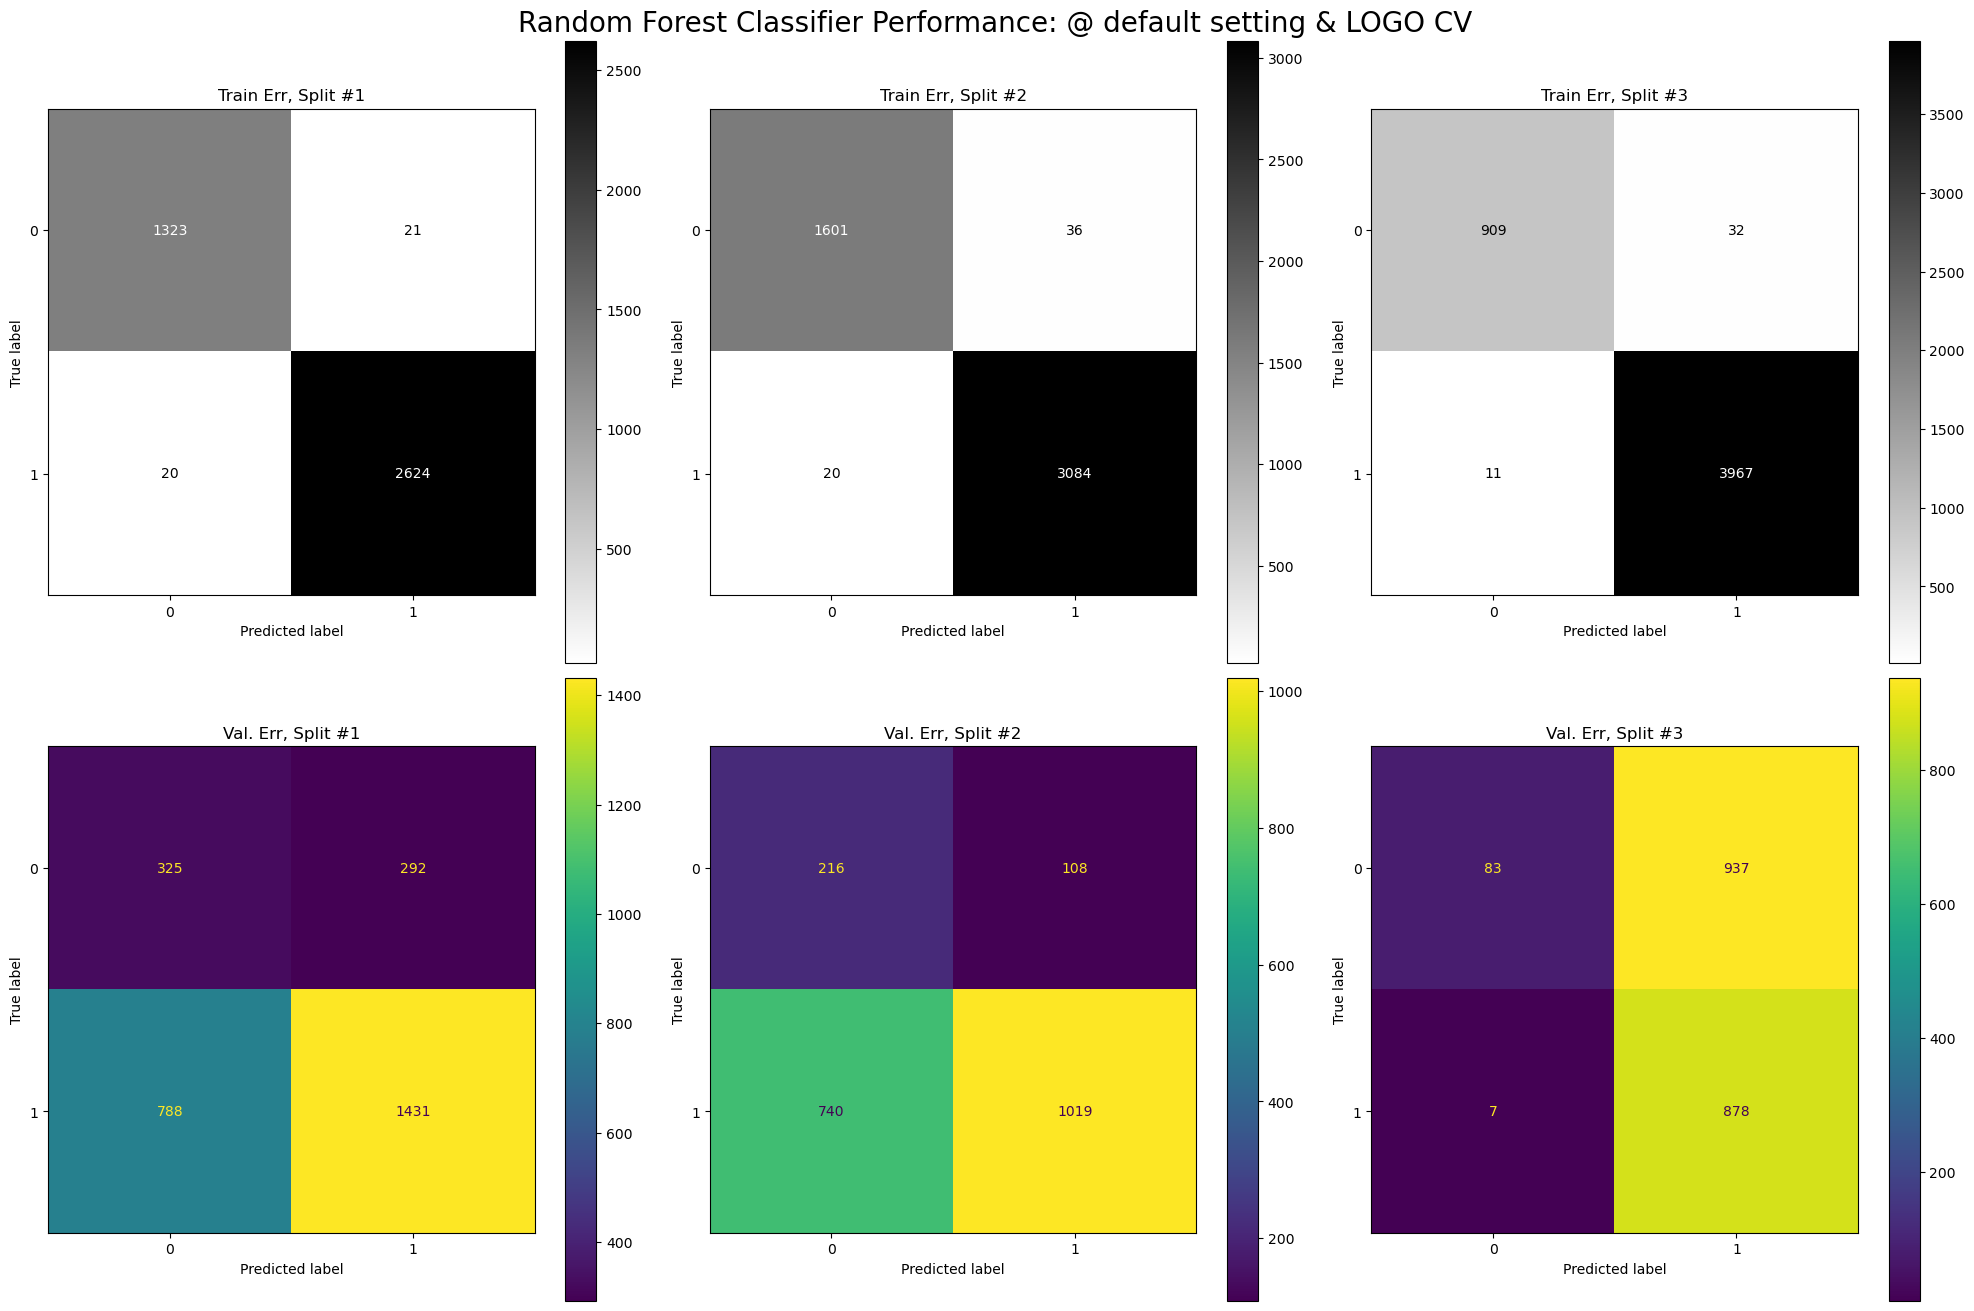

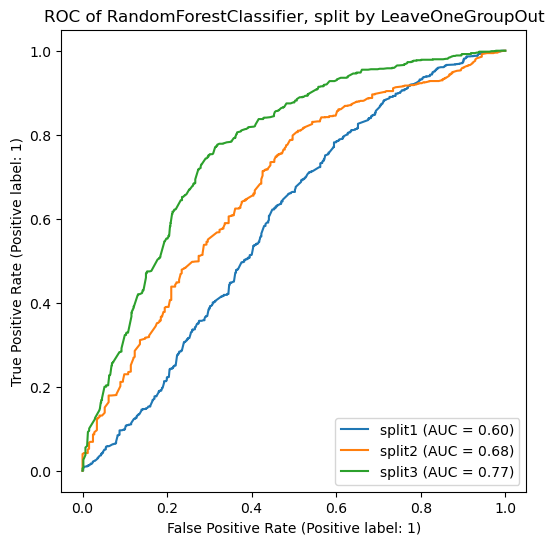

In [16]:
# make a random forest classifier
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=100, random_state=0)

# perform LOCO-cv
CrossValidate(RFC, X, y, task_type = 'classification', splitter = LOGO, cv_label=labels, 
              title = 'Random Forest Classifier Performance: @ default setting & LOGO CV')

_THOUGHTS: training was again good. Validation was not ideal, but notably better then decision tree_

### NOTE about tuning hyper-parameters with LOCO CV: 
Now we move on to tune the hyperparameters. We use LOCOCV to tune because 

1. random CV results are less exciting: the deeper we go, and the more trees we have, the higher the score, and 

2. we want to predict on our previous Co-Ti-Cr-Zr tertiary system, which require very robust model with some power to extrapolate.

Optimal Parameteres:  {'max_depth': 16, 'n_estimators': 100}


Text(50.722222222222214, 0.5, 'max_depth')

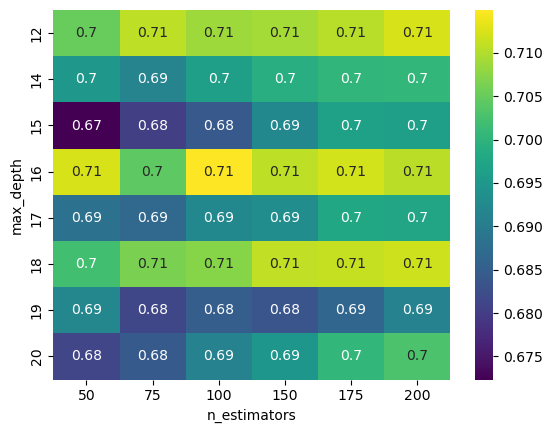

In [17]:
# tune parameters based on loco-cv
params = {'n_estimators': [50, 75, 100, 150, 175, 200],
          'max_depth': [12, 14, 15, 16, 17, 18, 19, 20]}

# to make the model more robust, we standardize the data
X_std = StandardScaler().fit_transform(X)

RFC = RandomForestClassifier(random_state=1)
GSCV = GridSearchCV(RFC, param_grid=params, scoring='roc_auc', cv=LOGO, n_jobs=-1
                    ).fit(X_std, y, groups=labels)

print('Optimal Parameteres: ', GSCV.best_params_)

Z = GSCV.cv_results_['mean_test_score'].reshape(
    len(params['max_depth']), len(params['n_estimators']))

'''INSTEAD OF CONTOUR PLOT, we plot he heatmap as it allows better visualization of 
the numeric score of each combination'''
sb.heatmap(Z, cmap='viridis', annot=True, xticklabels=params['n_estimators'], 
           yticklabels=params['max_depth']);
plt.xlabel('n_estimators')
plt.ylabel('max_depth')

_On the graph above the models' performance are similar. We will select max depth of 16 and n of estimator to be 100 as we favor simpler model._

NOW we train the RFC with the optimum hyperparameters, then report its performance 

Val. AUC at split 1 0.5643568912362147
Val. AUC at split 2 0.6385800714491258
Val. AUC at split 3 0.5267032236623462


/Users/baishipu/Desktop/403 Python/MSE403 Baishi Pu 1004916184/Assi 8/CustomFunctions.py:626: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


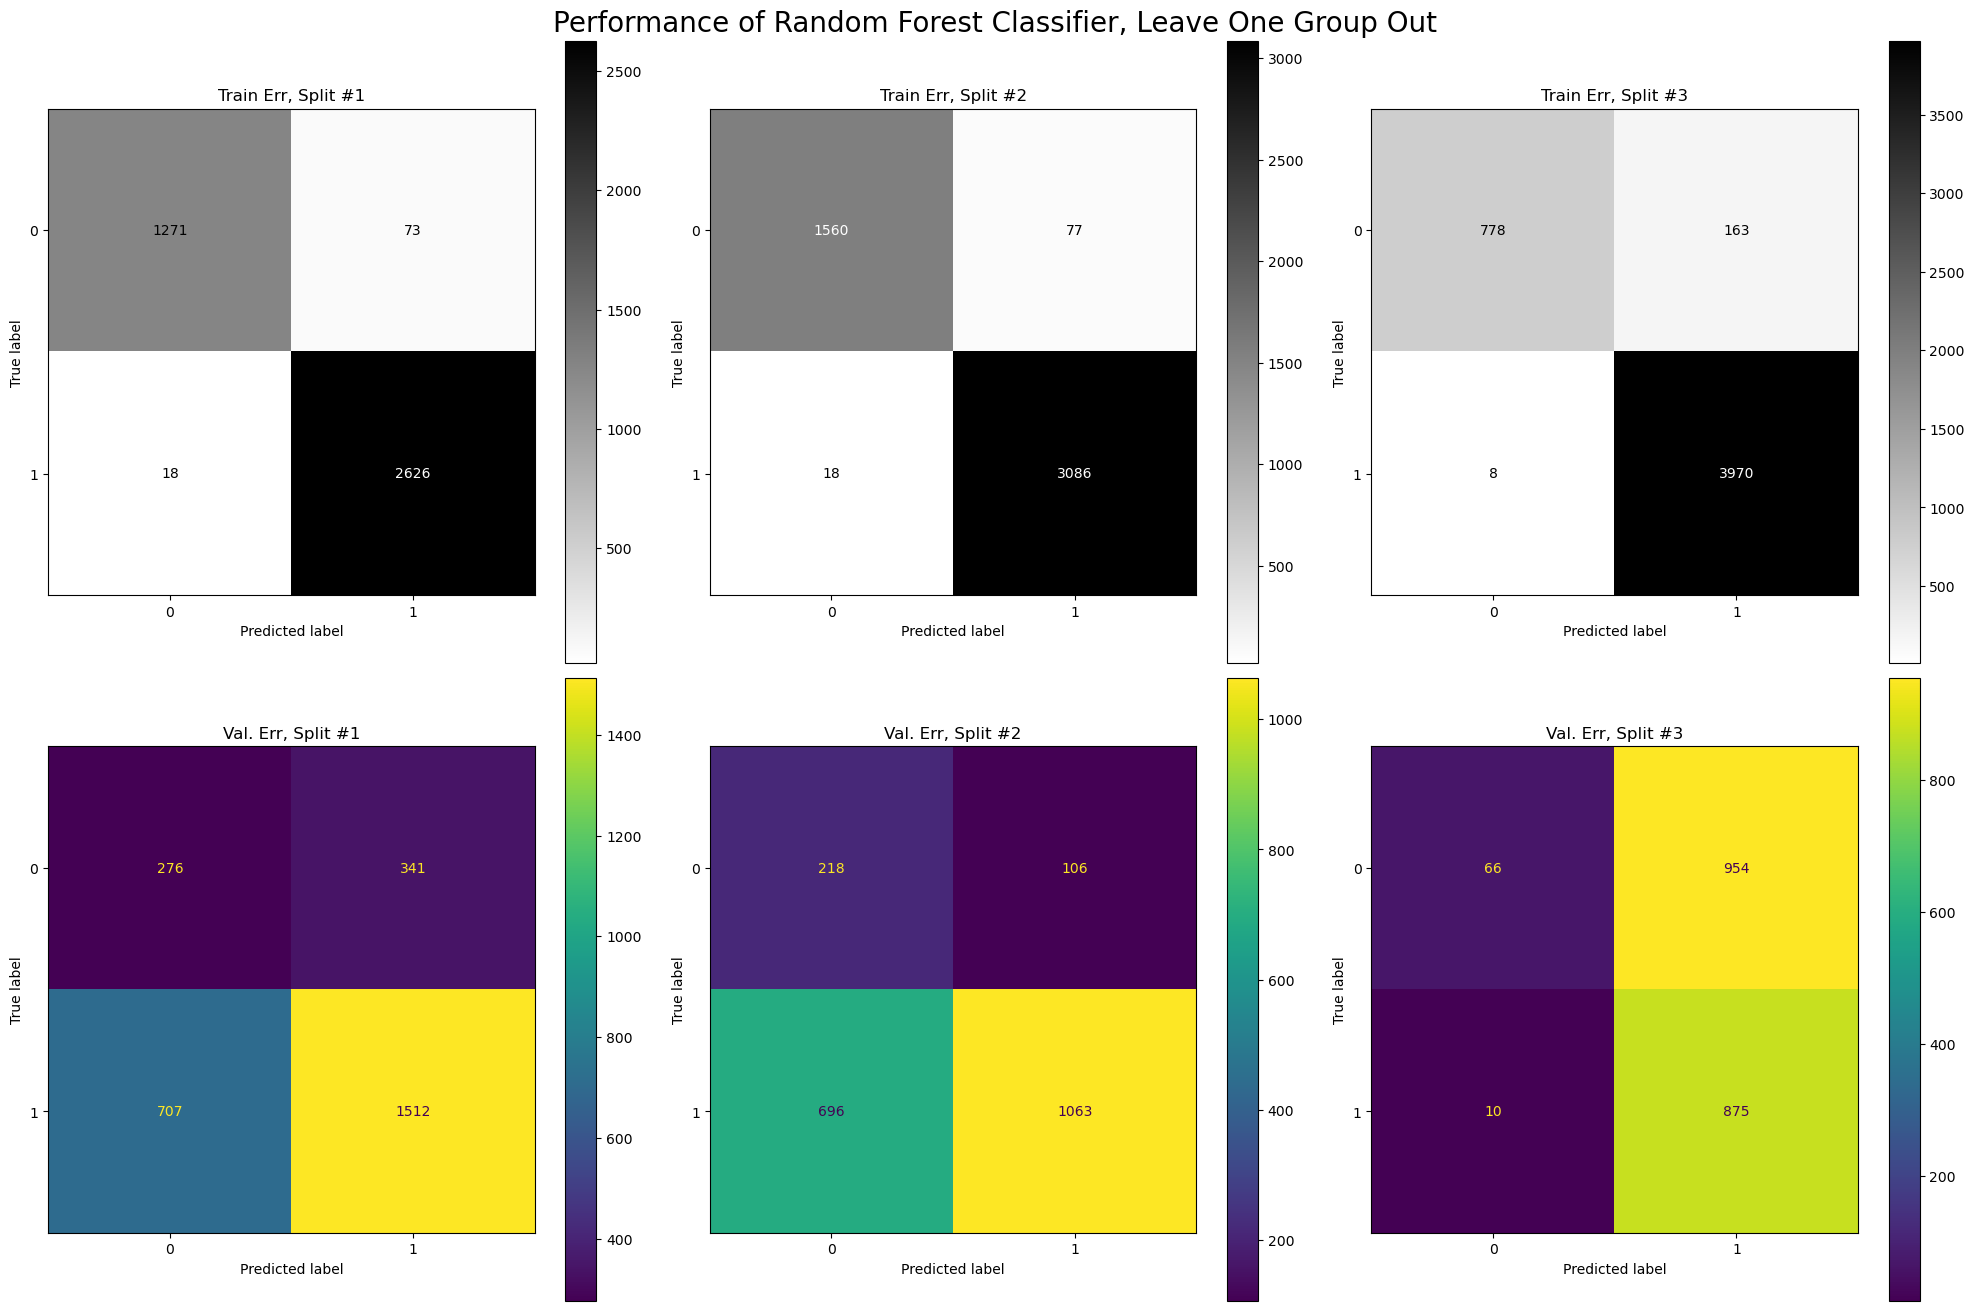

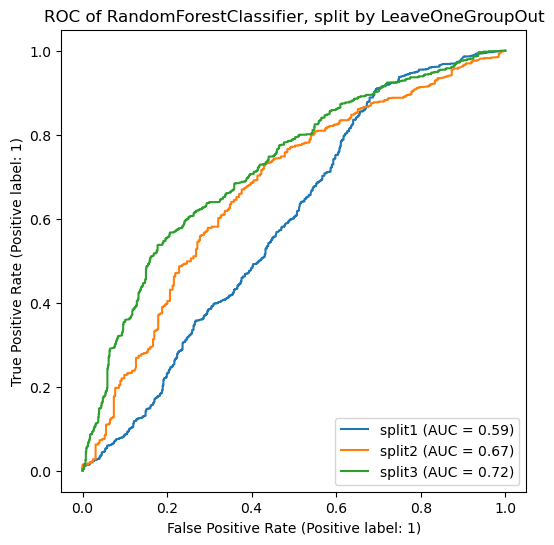

In [19]:
RFC = RandomForestClassifier(n_estimators=75, max_depth=15)

CrossValidate(RFC, X_std, y, task_type = 'classification', splitter = LOGO, cv_label=labels,
                title = 'Performance of Random Forest Classifier, Leave One Group Out')

### NOTE: 
As required by assignment, we can also tune parameters by random CV with the code below (but loco-cv will be a harsher test)

Val. AUC at split 1 0.854320570472997
Val. AUC at split 2 0.8579225580490336
Val. AUC at split 3 0.8391285356911226
Val. AUC at split 4 0.8447620417557126


/Users/baishipu/Desktop/403 Python/MSE403 Baishi Pu 1004916184/Assi 8/CustomFunctions.py:626: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


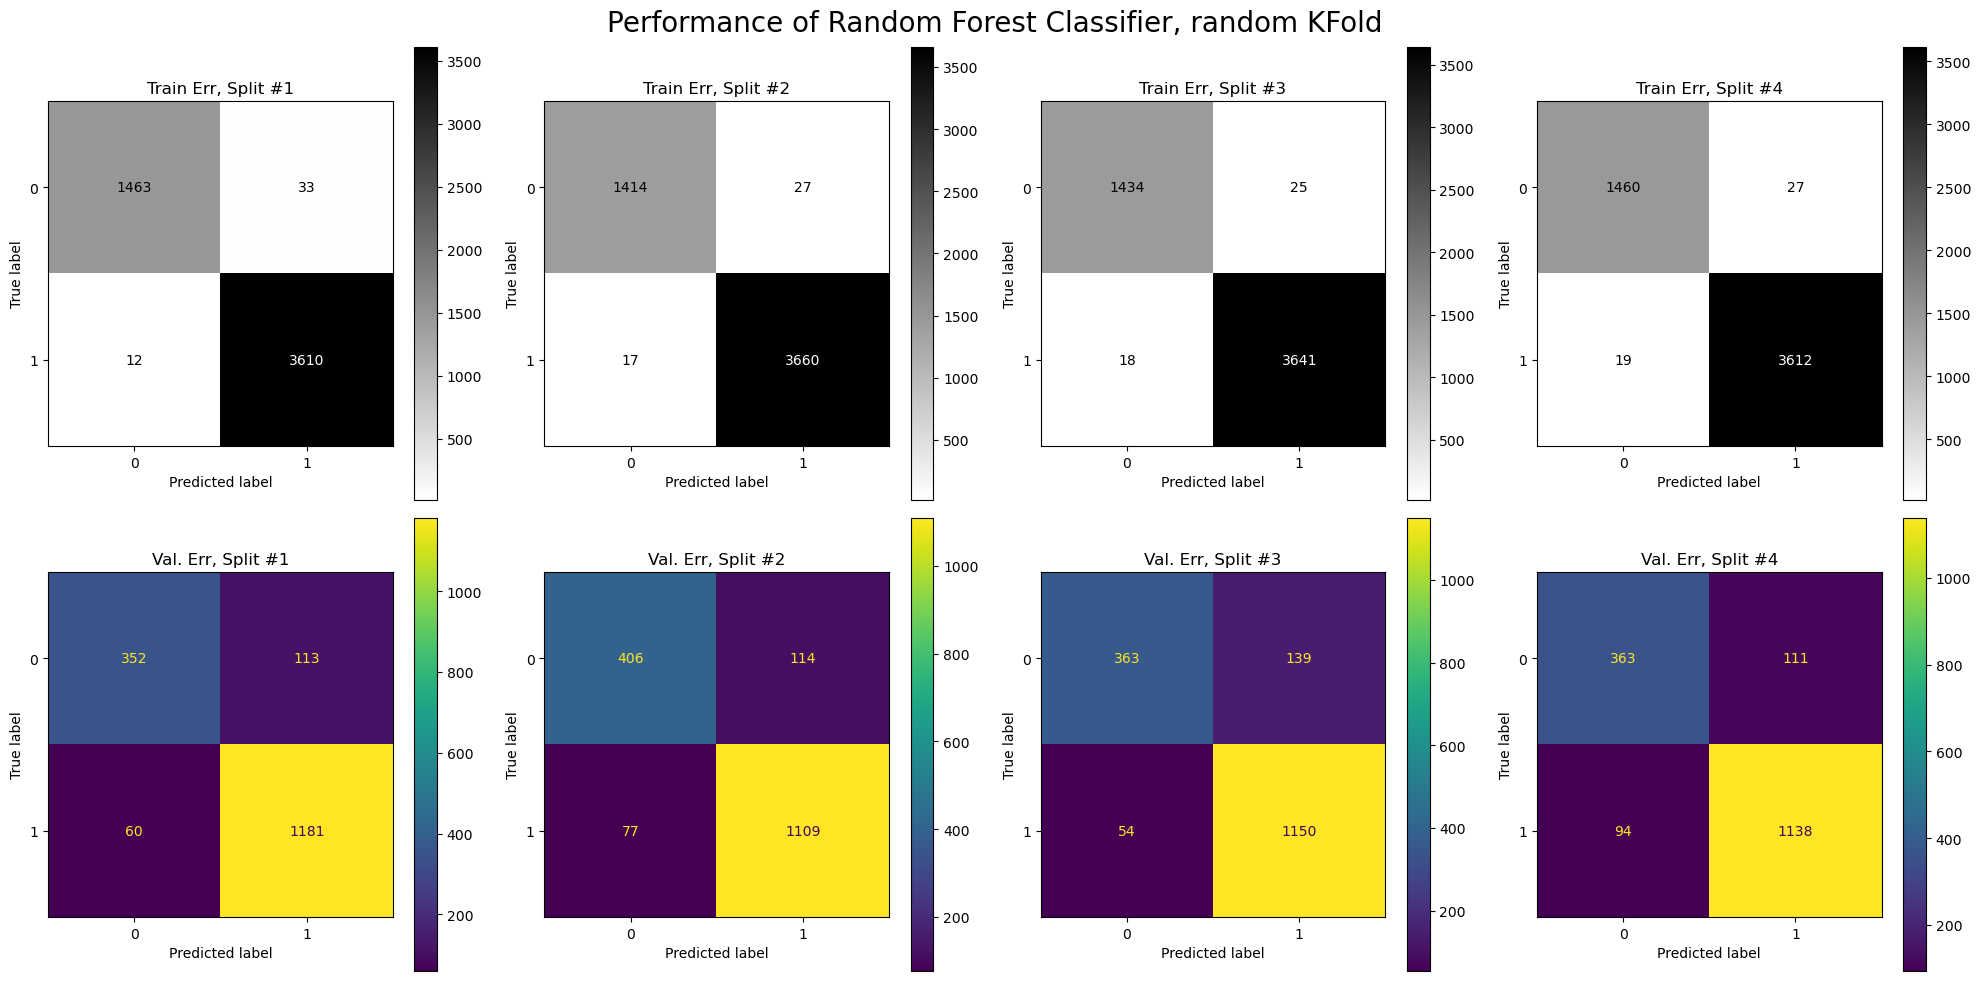

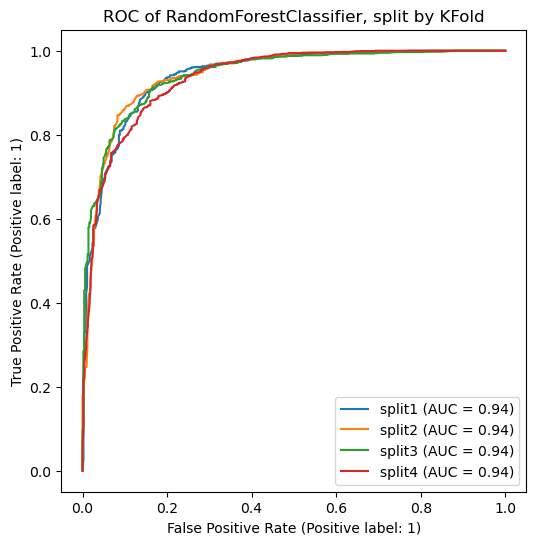

In [ ]:

KF = KFold(n_splits=4, shuffle=True, random_state=0)
CrossValidate(RFC, X_std, y, task_type = 'classification', splitter = KF, cv_label=labels,
                title = 'Performance of Random Forest Classifier, random KFold');

### 4. Predict glass formability in Co-Zr-Cr-Ti quaternary system

In [20]:
# make an empty df2 which has the same column names as df but without the column 'isGlass'
dff2 = pd.DataFrame(columns = ['Co', 'Ti', 'Cr', 'Zr'])

for Co in np.arange(0, 1, 0.05):
    for Ti in np.arange(0, 1-Co, 0.05):
        for Cr in np.arange(0, 1-Co-Ti, 0.05):
            row = pd.DataFrame({'Co': Co, 'Ti': Ti, 'Cr': Cr, 'Zr': 1-Co-Ti-Cr}, index=[0])
            dff2 = pd.concat([dff2, row], ignore_index = True)

dff2.insert(0, 'formula', 
           'Co' + dff2['Co'].astype(str) + 'Ti' + dff2['Ti'].astype(str) + 
           'Cr' + dff2['Cr'].astype(str) + 'Zr' + dff2['Zr'].astype(str))

dff2

,formula,Co,Ti,Cr,Zr
0,Co0.0Ti0.0Cr0.0Zr1.0,0.00,0.00,0.00,1.00
1,Co0.0Ti0.0Cr0.05Zr0.95,0.00,0.00,0.05,0.95
2,Co0.0Ti0.0Cr0.1Zr0.9,0.00,0.00,0.10,0.90
3,Co0.0Ti0.0Cr0.15000000000000002Zr0.85,0.00,0.00,0.15,0.85
4,Co0.0Ti0.0Cr0.2Zr0.8,0.00,0.00,0.20,0.80
...,...,...,...,...,...
1544,Co0.8500000000000001Ti0.1Cr0.0Zr0.049999999999...,0.85,0.10,0.00,0.05
1545,Co0.9Ti0.0Cr0.0Zr0.09999999999999998,0.90,0.00,0.00,0.10
1546,Co0.9Ti0.0Cr0.05Zr0.049999999999999975,0.90,0.00,0.05,0.05
1547,Co0.9Ti0.05Cr0.0Zr0.049999999999999975,0.90,0.05,0.00,0.05


In [21]:
# dff2 = StrToComposition().featurize_dataframe(dff2, 'formula')
# dff2 = AtomicPackingEfficiency().featurize_dataframe(dff2, col_id='composition')
# dff2 = Miedema().featurize_dataframe(dff2, col_id='composition')
# dff2 = Meredig().featurize_dataframe(dff2, col_id='composition')
# dff2 = WenAlloys().featurize_dataframe(dff2, col_id='composition')

# ### drop rows: drop NaNs, drop abnormal Yangs
# # drop the rows with nan
# dff2 = dff2.dropna()
# # record the row index of dff2 where Yang omega is greater than 100
# index = dff2[dff2['Yang omega'] > 100].index
# # drop the rows with Yang omega greater than 100 (in both featureized and unfeatureized df)
# dff2 = dff2.drop(index)

# # write dff2 into an excel file
# dff2.to_excel('dff2.xlsx', index=False)
# # then rearrange & preserve only the columns that are in features (a df)

In [23]:
### similar to before, some basic data cleaning. 
dff2 = pd.read_excel('dff2.xlsx')

# make a Yang_df with only the Yang features. We'll use this for plotting
Yang_df2 = dff2[['Yang delta', 'Yang omega']]
features2 = dff2.copy()
# extract column names from df
cols = features.columns
# filter columns in df2 to include only those in cols
features2 = dff2[cols]
# reorder columns in df2 to match the order in cols
features2 = features2.reindex(columns=cols)

In [24]:
# from the features above we'll have our X. 
# and y is the predicted value of isGlass, by both models

X2 = features2.values
X2_std = StandardScaler().fit_transform(X2)

y_DTC = DTC.predict(X2_std)
y_RFC = RFC.predict(X2_std)

# df2 is the column in dff2 where columns are Co, Ti, Cr, Zr
df2 = dff2.loc[:,['Co', 'Ti', 'Cr', 'Zr']]
# add the predicted values to the dff2
df2['isAmor_DTC'] = y_DTC
df2['isAmor_RFC'] = y_RFC

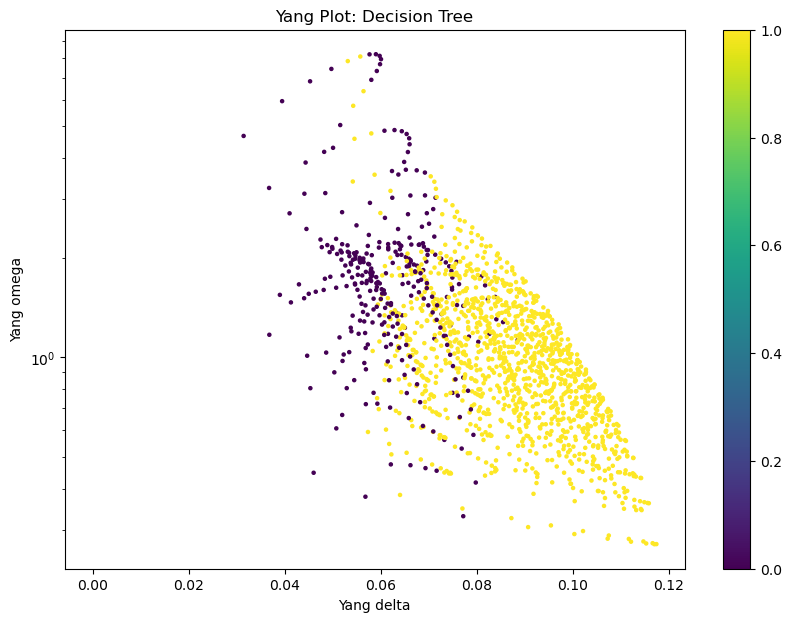

In [28]:
from CustomFunctions import plot_yang
# plot the predicted values
# make a plot with two subplots
plt.figure(figsize=(10, 7))
plot_yang(Yang_df2, plot_title = 'Yang Plot: Decision Tree', color_label = y_DTC)

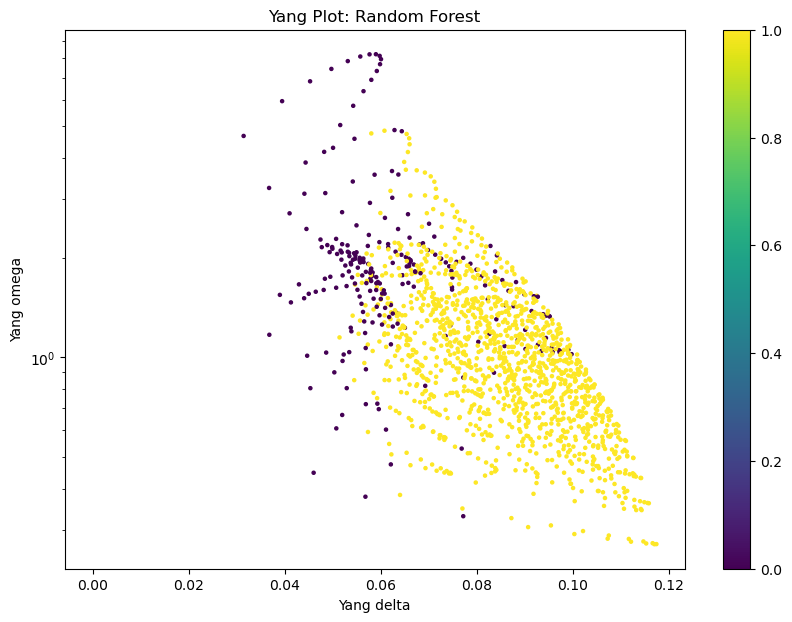

In [26]:
plt.figure(figsize=(10, 7))
plot_yang(Yang_df2, plot_title = 'Yang Plot: Random Forest', color_label = y_RFC)

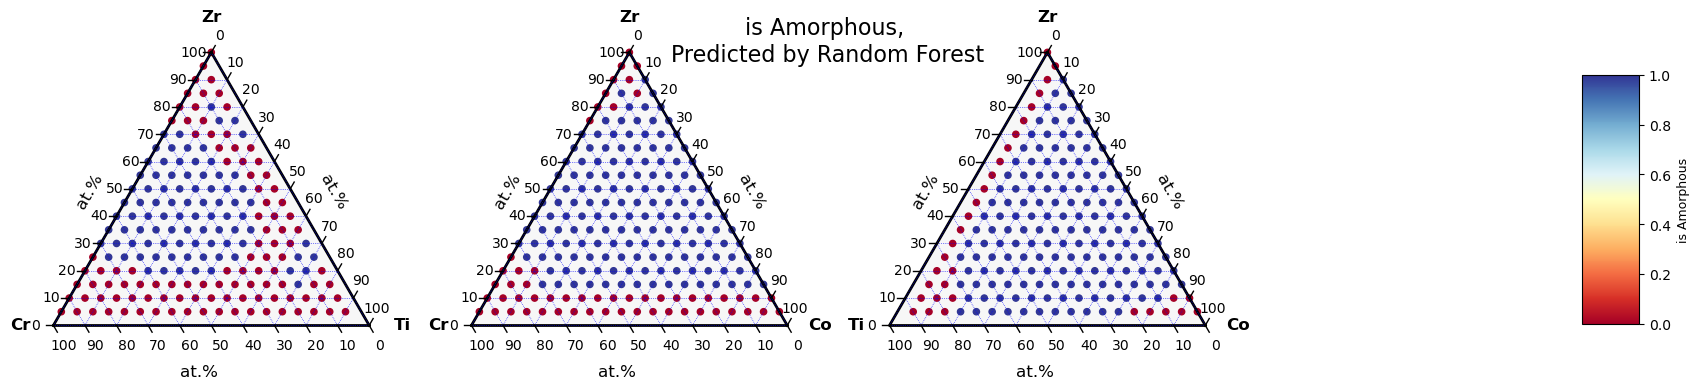

In [29]:
# Last, make tertiary diagrams from Random Forest's prediction
from CustomFunctions import df_plot_ternary

# make a diagram for the presiction of Random Forest
missing = ['Co', 'Ti', 'Cr']
fig, axs = plt.subplots(1, 4, figsize = (17, 4))
fig.tight_layout(pad = 2.0)
fig.suptitle('is Amorphous, \nPredicted by Random Forest', fontsize = 16)
for i, e in enumerate(missing):
    df_pred_copy = df2.copy()
    # in df_pred_copy, drop the rows where e is not 0
    df_pred_copy = df_pred_copy[df_pred_copy[e] == 0]
    # drop the column e
    df_pred_copy = df_pred_copy.drop(e, axis = 1)
    # plot ternary diagram
    ax = axs[i]
    df_plot_ternary(df_pred_copy, df_pred_copy.loc[:, 'isAmor_DTC'], 'is Amorphous', ax = ax, cmap = plt.cm.RdYlBu)

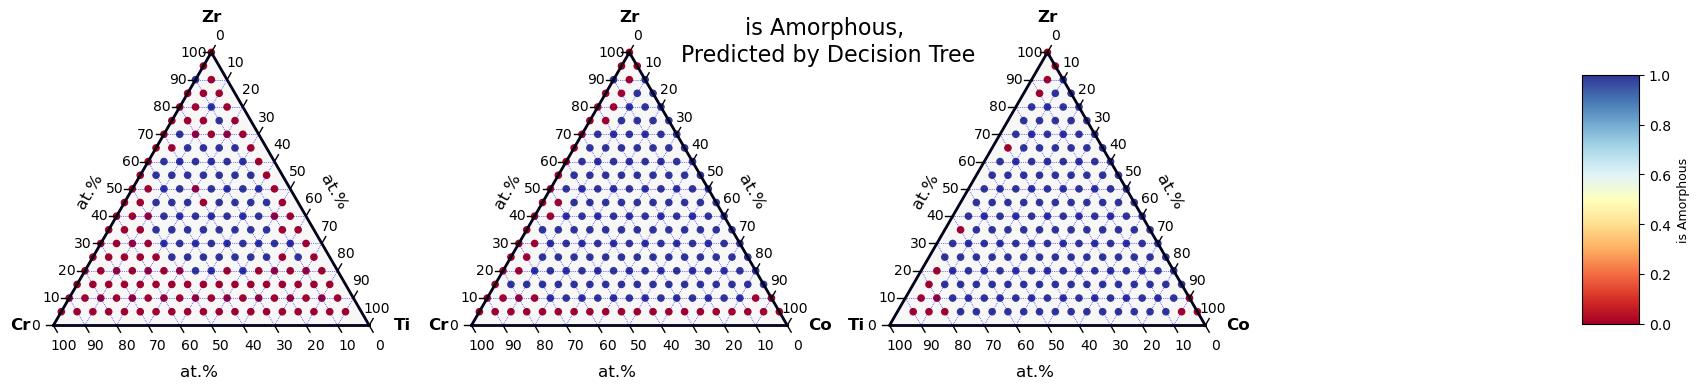

In [30]:
# Last, make tertiary diagrams for Decision Tree
from CustomFunctions import df_plot_ternary

fig, axs = plt.subplots(1, 4, figsize = (17, 4))
fig.tight_layout(pad = 2.0)
fig.suptitle('is Amorphous, \nPredicted by Decision Tree', fontsize = 16)
for i, e in enumerate(missing):
    df_pred_copy = df2.copy()
    # in df_pred_copy, drop the rows where e is not 0
    df_pred_copy = df_pred_copy[df_pred_copy[e] == 0]
    # drop the column e
    df_pred_copy = df_pred_copy.drop(e, axis = 1)
    # plot ternary diagram
    ax = axs[i]
    df_plot_ternary(df_pred_copy, df_pred_copy.loc[:, 'isAmor_RFC'], 'is Amorphous', ax = ax, cmap = plt.cm.RdYlBu)

Let's look at what the actual glass distribution is like:

<img src='Actual Glass Distribution.png' width='800' align='left' />

### Reflection:

Overall the predicted results is not as comparable as the ternary diagrams trained on the three ternary dataset. Most notably, the glass region are much larger. But this model does have some predictive power as it predicts 1. alloys that are amorphous usually have high Yang delta and 2.pure elements are unlikely to form amorphous phases. 

Standardizing the training & test set did not affect the tree's structure (at least for this dataset), but did made the model more stable & robust. Feature importance histogram were generated under different X, and it was found that When the data is standardized, the primary feature takes much higher importance (Radii mismatch from 0.6 -> 0.8), which could be the reason for a more robust model.

